In [227]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [233]:
# Use GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
        device = torch.device("cpu")
print("Using device:", device)

Using device: mps


# Data generation


In [9]:
def generate_data(n, d, rho, eta, seed=0):
    rng = np.random.default_rng(seed)
    
    # Construction of mu_1 and mu_2
    v1 = rng.normal(size=d)
    v1 /= np.linalg.norm(v1) # normalize

    v2 = rng.normal(size=d)
    v2 -= (v2 @ v1) * v1 # remove projection of mu_2 onto mu1 to ensure orthogonality
    v2 /= np.linalg.norm(v2) # normalize

    mu_1 = rho * v1
    mu_2 = rho * v2

    # Covariance matrix
    I_d = np.eye(d)
    Sigma = I_d - (np.outer(mu_1, mu_1) + np.outer(mu_2, mu_2)) / (rho**2)

    # Generate labels
    y = rng.choice([+1, -1], size=n)

    # Generate noise and signal
    noise = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
    
    # mu_1 if y = +1, mu_2 if y = -1
    signals = np.where(y[:, None] == 1, mu_1, mu_2)

    # Assign to tokens
    X = np.empty((n, 2, d), dtype=float)
    token_choices = rng.integers(low=0, high=2, size=n)
    X[np.arange(n), token_choices, :] = signals
    X[np.arange(n), 1 - token_choices, :] = noise

    # Flip labels with probability eta
    rng_flip = np.random.default_rng(seed + 1)
    flip_mask = rng_flip.random(n) < eta
    y_flipped = y.copy()
    y_flipped[flip_mask] = -y_flipped[flip_mask]

    # Indices
    clean_indices = np.where(~flip_mask)[0]
    noisy_indices = np.where(flip_mask)[0]

    return X, y_flipped, clean_indices, noisy_indices


In [225]:
# Parameters
batch_size = 50
n_train    = 40
n_test     = 40
d          = 6000
rho        = 5.0
eta        = 0.1
beta       = 0.025  

In [226]:
X_train_np, y_train_np, clean_indices_train, noisy_indices_train = generate_data(n_train, d, rho, eta= 0.1)
X_test_np,  y_test_np, clean_indices_test, noisy_indices_test = generate_data(n_test, d, rho, eta= 0.1)


X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.float32, device=device)


X_train[clean_indices_train].shape

torch.Size([37, 2, 6000])

# Single head attention


In [2]:
range = 0.01

class SingleHeadAttention(nn.Module):
    """
    Implements f(X; p, v) = v^T X^T softmax(X p),
    where X is (batch_size, 2, d),
          p, v are (d,).
    """
    def __init__(self, d):
        super().__init__()
        # Initialization of p and v
        self.p = nn.Parameter(torch.randn(d) * range)
        self.v = nn.Parameter(torch.randn(d) * range)

    def forward(self, X):
        # Compute the raw "logits" for attention: X p
        logits = X @ self.p  # (batch_size, 2, d) @ (d,) -> (batch_size, 2)
        
        # Apply softmax across the two tokens (dim=1)
        attn_weights = F.softmax(logits, dim=1) #(batch_size, 2)
        
        # Compute the weighted sum of the 2 tokens:
        weighted_sum = (attn_weights.unsqueeze(-1) * X).sum(dim=1) # (batch_size, d)
        
        # Dot product with v for each sample
        output = (weighted_sum * self.v).sum(dim=1) # (batch_size,)

        return output



# Plot function

In [168]:
def plot_metrics(train_acc, test_acc, clean_probs, noisy_probs):
    """
    Plot the metrics during training: train/test accuracies and softmax probabilities.
    """
    # Plot Train and Test Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_acc)), train_acc, label='Train Accuracy')
    plt.plot(range(len(test_acc)), test_acc, label='Test Accuracy')
    plt.xscale('log')
    plt.xlabel('Iteration (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy during Training')
    plt.autoscale(enable=True, axis='y')  # Autoscale y-axis
    plt.legend()

    # Plot Softmax Probabilities for Clean and Noisy Samples
    plt.subplot(1, 2, 2)
    plt.plot(range(len(clean_probs)), clean_probs, label='Clean Sample Probabilities')
    plt.plot(range(len(noisy_probs)), noisy_probs, label='Noisy Sample Probabilities')
    plt.xscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Softmax Probability')
    plt.title('Softmax Probability of Signal Token')
    plt.autoscale(enable=True, axis='y')  # Autoscale y-axis
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gradient Descent

### Metrics and loss

In [228]:
def logistic_loss_fn(logits, labels):
    return torch.mean(torch.log(1.0 + torch.exp(-labels * logits)))

def accuracy_score(logits, labels):
    preds = torch.sign(logits)  # get +1 or -1
    correct = (preds == labels).sum().item()
    return correct / len(labels)

### Training with Gradient Descent

In [196]:
def train_with_gradient_descent(model, optimizer, log_every=50, num_steps=150):

    # Initialize lists and step
    train_accs, test_accs, clean_proba, noisy_proba, steps_list = [0.01], [0.01], [], [], []
    cur_step = 0

    # Descent
    for epoch in range(num_steps):
        pred = model(X_train)
        loss = logistic_loss_fn(pred, y_train)

        # Backprop
        optimizer.zero_grad()
        model.zero_grad()
        with torch.no_grad():
            # Predictions on the training set
            pred = model(X_train)
            train_acc = accuracy_score(pred, y_train)

            # Predictions on the test set
            logits_test = model(X_test)
            test_acc = accuracy_score(logits_test, y_test)
            
            logits_clean = torch.matmul(X_train[clean_indices_train], model.p)  # Adjust to model.p shape
            probs_clean = F.softmax(logits_clean, dim=1)[:, 0].cpu().numpy()
            clean_probs_iter = np.mean(probs_clean)

            logits_noisy = torch.matmul(X_train[noisy_indices_train], model.p)  # Adjust to model.p shape
            probs_noisy = F.softmax(logits_noisy, dim=1)[:, 0].cpu().numpy()
            noisy_probs_iter = np.mean(probs_noisy)


        train_accs.append(train_acc)
        test_accs.append(test_acc)
        steps_list.append(cur_step)
        clean_proba.append(clean_probs_iter)
        noisy_proba.append(noisy_probs_iter)


        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= beta * param.grad
            
        # Logging tous les epochs
        cur_step += 1
        if (epoch==0) or (epoch+1)%log_every==0 or (epoch+1 == num_steps):
            print(f"Epoch {epoch+1}")


    plot_metrics(train_accs, test_accs, clean_proba, noisy_proba)
    return model


Epoch 1
Epoch 50
Epoch 100
Epoch 150


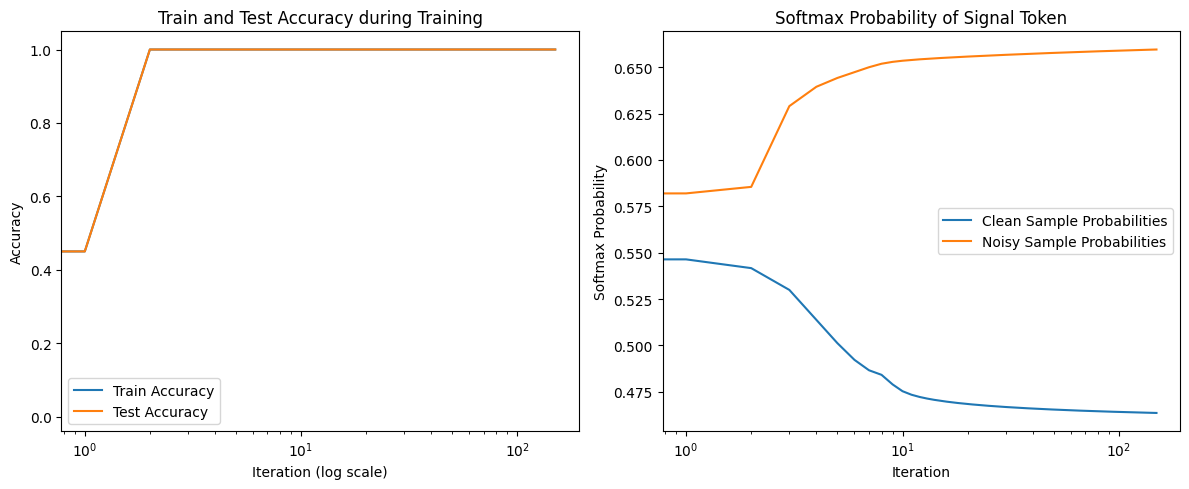

In [202]:
# Model and Optimizer
model_gradient_descent = SingleHeadAttention(d).to(device)
optimizer_gradient_descent = torch.optim.SGD(model_gradient_descent.parameters(), lr=beta)

model_with_gradient_descent = train_with_gradient_descent(model_gradient_descent, optimizer_gradient_descent)

### Max-Margin Solution

In [204]:
# Parameters
r = np.sqrt(d)
R = np.sqrt(d)*0.1
margin_lambda = 1.0

In [231]:
def train_with_max_margin(model, optimizer, log_every=50, num_steps=150):

    # Initialize lists and step
    train_accs, test_accs, clean_proba, noisy_proba, steps_list = [0.01], [0.01], [], [], []
    cur_step = 0

    # Descent
    for epoch in range(num_steps):
        pred = model(X_train)
        loss = logistic_loss_fn(pred, y_train)

        # Backprop
        optimizer.zero_grad()
        model.zero_grad()
        with torch.no_grad():
            # Predictions on the training set
            pred = model(X_train)
            train_acc = accuracy_score(pred, y_train)

            # Predictions on the test set
            logits_test = model(X_test)
            test_acc = accuracy_score(logits_test, y_test)

            # Add accs to lists
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            
            logits_clean = torch.matmul(X_train[clean_indices_train], model.p)  # Adjust to model.p shape
            probs_clean = F.softmax(logits_clean, dim=1)[:, 0].cpu().numpy()
            clean_probs_iter = np.mean(probs_clean)

            logits_noisy = torch.matmul(X_train[noisy_indices_train], model.p)  # Adjust to model.p shape
            probs_noisy = F.softmax(logits_noisy, dim=1)[:, 0].cpu().numpy()
            noisy_probs_iter = np.mean(probs_noisy)


            # clean_probs_iter = np.mean(F.softmax(np.dot((X_train[clean_indices_train], model.p).cpu()))[:, 0])
            # noisy_probs_iter = np.mean(F.softmax(np.dot((X_train[noisy_indices_train], model.p).cpu()))[:, 0])


        steps_list.append(cur_step)
        clean_proba.append(clean_probs_iter)
        noisy_proba.append(noisy_probs_iter)


        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= beta * param.grad
            
        # Logging tous les epochs
        cur_step += 1
        if (epoch==0) or (epoch+1)%log_every==0 or (epoch+1 == num_steps):
            print(f"Epoch {epoch+1}")


    plot_metrics(train_accs, test_accs, clean_proba, noisy_proba)
    return model


Epoch 1
Epoch 50
Epoch 100
Epoch 150


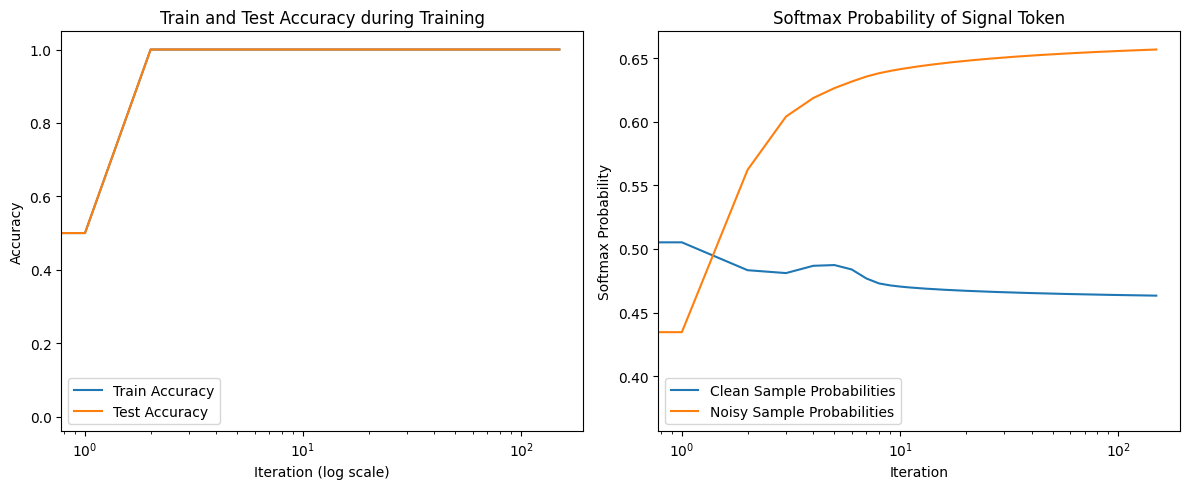

In [234]:
model_max_margin = SingleHeadAttention(d).to(device)
optimizer_max_margin = torch.optim.SGD(model_max_margin.parameters(), lr=beta)

model_max_margin = train_with_max_margin(model_max_margin, optimizer_max_margin)